# 0. Setup

In [4]:
# %pip install --upgrade langchain langsmith langgraph langchain_openai openai python-dotenv javascript numpy genson
%reload_ext autoreload
%autoreload 2

In [5]:
# Setup
from dotenv import load_dotenv
import os
from langchain_core.messages import HumanMessage
from graph.trivial_agent_graph import IndexerAgentGraphBuilder
from agents.IndexerAgent import indexer_agent_model, tool_executor
from tools.JavaScriptRunner import tool_js_on_block_schema_func, tool_js_on_block_schema
from agents.BlockExtractorAgent import run_js_on_block_only_schema,JsResponse
import json
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

# Master Run

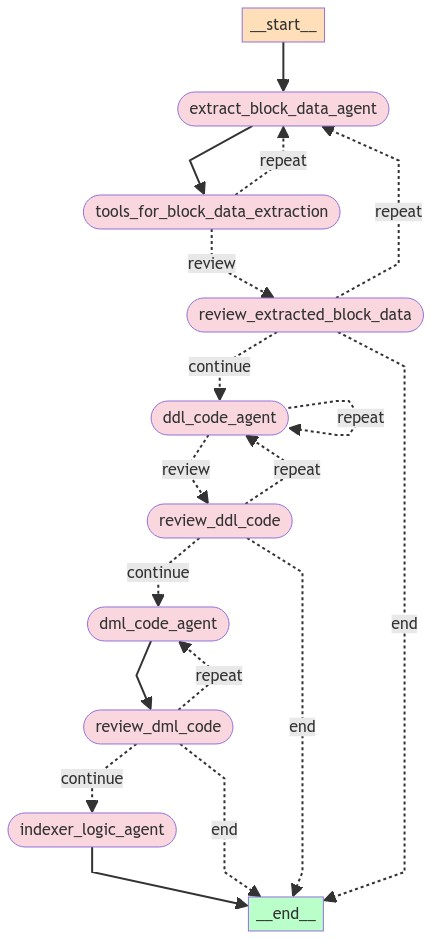

In [6]:
from graph.master_graph import create_graph
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
    Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
    Use block height 119688212 for parsing the JS code, and only pull data from the last 1 day.
    """        

inputs = {
    "messages":[HumanMessage(content=question)],
    "block_schema": "",
    "block_heights":[], # TO DO: Add in block height logging
    "js_code":"",
    "ddl_code":"",
    "dml_code": "",
    "indexer_logic":"",
    "iterations": 0,
    "error":"",
    "should_continue": False,
    }

workflow = create_graph()
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# result = app.invoke(inputs)

In [7]:
# ddl_code = result['ddl_code']
# js_code = result['js_code']
# dml_code = result['dml_code']
# indexer_logic = result['indexer_logic'].replace("\\n","\n")
# print(f'SQL DDL: {ddl_code}')
# print(f'Indexer Logic: {indexer_logic}')

# Scratchpad

Spencer
- To Do: Add loop within JS agent to check code - WIP (currently hardcoded)
- Think about how to work for multiple entities

Pavel:
- Union of Schema
- Think about Unit Tests, leveraging trivial graph to test agents w/ tools
- Ways to test the indexer code, working with Darun

In [8]:
from graph.master_graph import GraphState
# from typing import TypedDict, Sequence
# from langchain_core.messages import BaseMessage
# from langchain.pydantic_v1 import BaseModel

# # Define Graphstate
# # class GraphState(BaseModel):
# class GraphState(BaseMessage):
#     """
#     Represents the state of our graph.

#     Attributes:
#         messages: With user questions, tracking plans, reasoning
#         block_heights: Block heights of the blocks to be parsed
#         js_code: Javascript code to be run on block schema
#         block_schema: Extracted block schema from json of blocks 
#         ddl_code: Data Definition Language code for creating tables
#         dml_code: Data manipulation language code for inserting data using context.db
#         iterations: Number of tries to generate the code
#         error: error message if any
#         should_continue: Binary flag for control flow to indicate whether to continue or not
#     """

#     messages: Sequence[BaseMessage]
#     block_heights: Sequence[int]
#     block_schema: str
#     js_code: str
#     ddl_code: str
#     dml_code: str
#     iterations: int
#     error: str
#     should_continue: bool

In [9]:
# Load agents
from tools.NearLake import tool_get_block_heights
from tools.JavaScriptRunner import tool_js_on_block_schema_func,tool_infer_schema_of_js
from agents.BlockExtractorAgent import BlockExtractorAgent,block_extractor_agent_model_v2
from agents.DDLAgent import DDLCodeAgent,ddl_code_model_v2,DDLResponse
from agents.DMLAgent import DMLCodeAgent,dml_code_model
from langgraph.prebuilt import ToolExecutor

# Block Extractor Agent
block_extractor_tools = [tool_js_on_block_schema_func, tool_infer_schema_of_js]
block_extractor_model = block_extractor_agent_model_v2(block_extractor_tools) # v2 adds the jsresponse parser to prompt
block_extractor_agent = BlockExtractorAgent(block_extractor_model,ToolExecutor(block_extractor_tools))

# DDL Agent
ddl_tools= [] #[tool_js_on_block_schema]
ddl_code_agent_model = ddl_code_model_v2(ddl_tools)
ddl_code_agent = DDLCodeAgent(ddl_code_agent_model,ToolExecutor(ddl_tools))

# DML Agent
dml_tools = []
dml_code_agent_model = dml_code_model(dml_tools)
dml_code_agent = DMLCodeAgent(dml_code_agent_model,ToolExecutor(dml_tools))

# 1. Block Extractor Agent

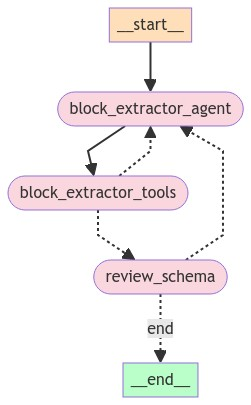

In [10]:
# Define conditional logic
def block_extractor_agent_router(state):
    last_message = state["messages"][-1]
    iterations = state['iterations']
    # If there is no tool call, then we review schema
    if not last_message.tool_calls:
        return "review_schema"
    # If more than X iterations have occurred end to prevent infinite loop
    elif iterations > 3:
        return "end"
    # Otherwise if there is, we call tools
    else:
        return "block_extractor_tools"
    
def should_review(state):
    block_schema = state["block_schema"]
    # If block schema is no longer null we review schema
    if block_schema != "":
        return "review_schema"
    else:
        return "block_extractor_agent"
    
def review_router(state):
    should_continue = state['should_continue']
    if should_continue==True:
        return "end"
    else:
        return "block_extractor_agent"
        

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)

## Tool Nodes
workflow.add_node("block_extractor_tools",block_extractor_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("block_extractor_agent", "block_extractor_tools")

# Add Conditional Edges
# Check if schema is filled in
workflow.add_conditional_edges(
    "block_extractor_tools",
    should_review,
    {
        "block_extractor_agent":"block_extractor_agent",
        "review_schema": "review_schema",
    }   
)
# Human review of schema
workflow.add_conditional_edges(
    "review_schema",
    review_router,
    {
        "block_extractor_agent": "block_extractor_agent",
        "end": END,
    }   
)

be_app = workflow.compile()
display(Image(be_app.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# from langchain_core.messages import HumanMessage

# question = """
#     Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
#     Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
#     Use block height 119688212 for parsing the JS code, and only pull data from the last 1 day.
#     """                    

# result = be_app.invoke({"messages": [HumanMessage(content=question)], 
#                     "block_schema": "",
#                     "block_heights":[],
#                     "js_code":"",
#                     "ddl_code":"",
#                     "dml_code": "",
#                     "iterations": 0,
#                     "error":"",
#                     "should_continue": False,
#                     })

# print(result)

In [12]:
# from tools.JavaScriptRunner import run_js_on_block

# print(result['block_schema'])

# code = result['js_code'].replace('\\n', '\n')
# print(code)

# block_schema = json.dumps(run_js_on_block(119688212, code))
# print(f"\n Attempted to parse on block: {block_schema}")

# 2. DDL Agent

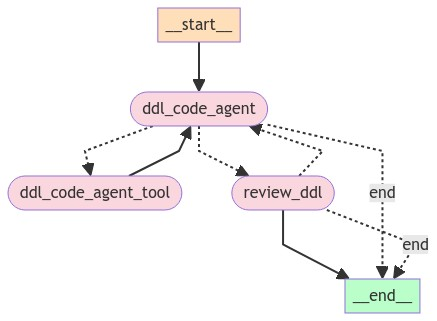

In [13]:
def ddl_code_agent_router(state):
    ddl_code = state.ddl_code
    iterations = state.iterations
    last_message = state.messages[-1]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "ddl_code_agent_tool"
        else:
            return "review_ddl"
    elif iterations > 3:
        return "end"
    elif ddl_code == "":
        return "ddl_code_agent"
    else:
        return "end"

def ddl_review_continue(state):
    should_continue = state.should_continue
    iterations = state.iterations
    if should_continue == True:
        return "end"
    elif iterations > 3:
        return "end"
    else:
        return "ddl_code_agent"

## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)

## Tool Nodes
workflow.add_node("ddl_code_agent_tool",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_ddl",ddl_code_agent.human_review)

## Add Edges
workflow.set_entry_point("ddl_code_agent")
workflow.add_edge("ddl_code_agent_tool", "ddl_code_agent")
workflow.add_edge("review_ddl", END)

# Add Conditional Edges
# Check if tools need to be run
workflow.add_conditional_edges(
    "ddl_code_agent",
    ddl_code_agent_router,
    {
        "ddl_code_agent_tool":"ddl_code_agent_tool",
        "review_ddl":"review_ddl",
        "end": END,
    }   
)
# Check if review passed
workflow.add_conditional_edges(
    "review_ddl",
    ddl_review_continue,
    {
        "ddl_code_agent":"ddl_code_agent",
        "end": END,
    }   
)

ddl_app = workflow.compile()

display(Image(ddl_app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block
js_code = """
function extractData(block) {
    const actions = block.actions();
    const receipts = block.receipts();
    const header = block.header();

    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);
    const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near' && action.operations.some(op => op.FunctionCall));

    const result = [];

    for (const action of filteredActions) {
      for (const operation of action.operations) {
        if (operation.FunctionCall) {
          const receipt = receipts.find(receipt => receipt.receiptId === action.receiptId);
          if (receipt) {
            const args = JSON.parse(atob(operation.FunctionCall.args));
            result.push({
              signerId: action.signerId,
              blockHeight: header.height,
              receiptId: action.receiptId,
              receipt: receipt,
              blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000),
              methodName: operation.FunctionCall.methodName,
              ...args
            });
          }
        }
      }
    }

    return result;
  }
  return extractData(block);
"""
block_schema = json.dumps(run_js_on_block(119688212, js_code))
print(block_schema)

[{"signerId": "app.nearcrowd.near", "blockHeight": 119688212, "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receipt": {"receiptKind": "Data", "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receiverId": "app.nearcrowd.near", "predecessorId": "app.nearcrowd.near", "status": {"SuccessValue": ""}, "executionOutcomeId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "logs": []}, "blockDatetime": "2024-05-25T06:05:09.183Z", "methodName": "finalize_challenged_task", "task_ordinal": 1, "task_hash": [72, 71, 99, 6, 192, 125, 179, 117, 56, 229, 134, 171, 164, 113, 202, 224, 134, 94, 128, 164, 179, 16, 26, 219, 5, 213, 32, 80, 108, 145, 244, 169]}]


In [15]:
# from langchain_core.messages import HumanMessage

# question = f"""
#     Take this block schema and generate DDL code to create normalized Postgresql tables.
# """

# result = ddl_app.invoke({"messages": [HumanMessage(content=question)], 
#                      "block_schema": block_schema,
#                      "block_heights":[],
#                      "js_code":js_code,
#                      "ddl_code":"",
#                      "dml_code": "",
#                      "indexer_logic": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result)

In [16]:
# print(result['ddl_code'])

# 3. DML Agent

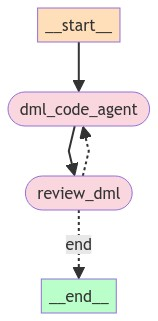

In [17]:
def dml_code_agent_router(state):
    should_continue = state.should_continue
    iterations = state.iterations
    if should_continue == True:
        return "end"
    elif iterations > 3:
        return "end"
    else:
        return "dml_code_agent"
    
## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("dml_code_agent", dml_code_agent.call_model)  # Plan the process

## Human Review
workflow.add_node("review_dml",dml_code_agent.human_review)

## Add Edges
workflow.set_entry_point("dml_code_agent")
workflow.add_edge("dml_code_agent","review_dml")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "review_dml",
    dml_code_agent_router,
    {
        "dml_code_agent":"dml_code_agent",
        "end": END,
    }   
)

dml_app = workflow.compile()
display(Image(dml_app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
psql = {
    "ddl": "CREATE TABLE IF NOT EXISTS block_data (\n    signer_id VARCHAR(255),\n    block_height BIGINT,\n    receipt_id VARCHAR(255) PRIMARY KEY,\n    receipt_kind VARCHAR(255),\n    receiver_id VARCHAR(255),\n    predecessor_id VARCHAR(255),\n    status_value VARCHAR(255),\n    execution_outcome_id VARCHAR(255),\n    logs JSONB,\n    block_datetime TIMESTAMP,\n    method_name VARCHAR(255),\n    task_ordinal INTEGER,\n    task_hash BYTEA\n);"
}
ddl_code = psql['ddl']
print(ddl_code)

CREATE TABLE IF NOT EXISTS block_data (
    signer_id VARCHAR(255),
    block_height BIGINT,
    receipt_id VARCHAR(255) PRIMARY KEY,
    receipt_kind VARCHAR(255),
    receiver_id VARCHAR(255),
    predecessor_id VARCHAR(255),
    status_value VARCHAR(255),
    execution_outcome_id VARCHAR(255),
    logs JSONB,
    block_datetime TIMESTAMP,
    method_name VARCHAR(255),
    task_ordinal INTEGER,
    task_hash BYTEA
);


In [19]:
from langchain_core.messages import HumanMessage

question = f"""
    Take this Postgresql schema and Javascript function for parsing parse blocks and generate DML code to upsert data into Postgresql tables.
"""

result = dml_app.invoke({"messages": [HumanMessage(content=question)], 
                     "block_schema": block_schema,
                     "block_heights":[],
                     "js_code":js_code,
                     "ddl_code":ddl_code,
                     "dml_code": "",
                     "indexer_logic":"",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

print(result)

{'messages': [HumanMessage(content='\n    Take this Postgresql schema and Javascript function for parsing parse blocks and generate DML code to upsert data into Postgresql tables.\n'), SystemMessage(content='\n            Postgresql schema: CREATE TABLE IF NOT EXISTS block_data (\n    signer_id VARCHAR(255),\n    block_height BIGINT,\n    receipt_id VARCHAR(255) PRIMARY KEY,\n    receipt_kind VARCHAR(255),\n    receiver_id VARCHAR(255),\n    predecessor_id VARCHAR(255),\n    status_value VARCHAR(255),\n    execution_outcome_id VARCHAR(255),\n    logs JSONB,\n    block_datetime TIMESTAMP,\n    method_name VARCHAR(255),\n    task_ordinal INTEGER,\n    task_hash BYTEA\n);\n            Javascript Function: \nfunction extractData(block) {\n    const actions = block.actions();\n    const receipts = block.receipts();\n    const header = block.header();\n\n    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);\n    const filteredActions = actions.filter(action 

In [20]:
print(result['js_code'])
print(result["dml_code"].replace('\\n','\n'))


function extractData(block) {
    const actions = block.actions();
    const receipts = block.receipts();
    const header = block.header();

    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);
    const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near' && action.operations.some(op => op.FunctionCall));

    const result = [];

    for (const action of filteredActions) {
      for (const operation of action.operations) {
        if (operation.FunctionCall) {
          const receipt = receipts.find(receipt => receipt.receiptId === action.receiptId);
          if (receipt) {
            const args = JSON.parse(atob(operation.FunctionCall.args));
            result.push({
              signerId: action.signerId,
              blockHeight: header.height,
              receiptId: action.receiptId,
              receipt: receipt,
              blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000),
       

In [21]:
# print(result['dml_code'])

# To Dos: 
# 1. Make sure to convert to pascal case when calling db. functions
# For example block_data should become BlockData
# 2. Don't use a for loop to insert data, map the data variables and feed them into the upsert
# 3. Make sure to include the previous JS (extract data for the final output)

# 4. Indexer Logic

In [22]:
dml_code = """
const data = extractData(block);\\nconst dmlStatements = data.map(item => {\\n    return `INSERT INTO function_calls (signer_id, block_height, receipt_id, receipt_kind, receipt_receiver_id, receipt_predecessor_id, receipt_status_success_value, receipt_execution_outcome_id, receipt_logs, block_datetime, method_name, task_ordinal, task_hash) VALUES ('${item.signerId}', ${item.blockHeight}, '${item.receiptId}', '${item.receipt.receiptKind}', '${item.receipt.receiverId}', '${item.receipt.predecessorId}', '${item.receipt.status.SuccessValue}', '${item.receipt.executionOutcomeId}', ARRAY[${item.receipt.logs.map(log => `'${log}'`).join(', ')}], '${item.blockDatetime.toISOString()}', '${item.methodName}', ${item.task_ordinal}, ARRAY[${item.task_hash.join(', ')}])';\\n});\\nawait UpsertFunctionCalls(dmlStatements);
"""
dml_code = dml_code.replace("\\n", "\n")

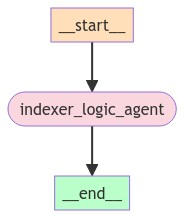

In [23]:
from agents.IndexerLogicAgent import indexer_logic_agent_model,IndexerLogicAgent

## Create IndexerLogic Graph
from langgraph.graph import END, StateGraph

indexer_logic_agent_model = indexer_logic_agent_model() #v2 no documentation
indexer_logic_agent = IndexerLogicAgent(indexer_logic_agent_model)

# Conditional Logic
def indexer_logic_agent_router(state):
    iterations = state.iterations
    if iterations > 3:
        return "end"
    else:
        return "reflect"

# Generate Graph
workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("indexer_logic_agent", indexer_logic_agent.call_model)  # Plan the process
# workflow.add_node("reflect_indexer_logic", indexer_logic_agent.reflection)  # Plan the process

## Add Edges
workflow.set_entry_point("indexer_logic_agent")
# workflow.add_edge("reflect_indexer_logic","indexer_logic_agent")
workflow.add_edge("indexer_logic_agent",END)

# workflow.add_conditional_edges(
#     "indexer_logic_agent",
#     indexer_logic_agent_router,
#     {
#         "reflect":"reflect_indexer_logic",
#         "end": END,
#     }
# )


il_app = workflow.compile()
display(Image(il_app.get_graph(xray=True).draw_mermaid_png()))

In [24]:
# from langchain_core.messages import HumanMessage

# question = f"""
#     Run Indexer Logic Agent
# """

# inputs = {"messages": [HumanMessage(content=question)], 
#             "block_schema": block_schema,
#             "block_heights":[],
#             "js_code":js_code,
#             "ddl_code":ddl_code,
#             "dml_code": dml_code,
#             "indexer_logic":"",
#             "iterations": 0,
#             "error":"",
#             "should_continue": False,
#             }

# result = il_app.invoke(inputs)

# print(result)

In [25]:
# print(result['indexer_logic'].replace("\\n","\n"))

# Full Graph [old]

In [26]:
# Conditional Edge logic
def should_block_schema_continue(state):
    last_message = state["messages"][-1]
    messages = state["messages"]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "continue"
        else:
            return "end"
    else:
        return "end"
    
def block_schema_review_continue(state):
    should_continue = state['should_continue']
    block_schema = state['block_schema']
    iterations = state['iterations']
    if should_continue == True:
        return "continue"
    elif iterations > 3:
        return "end"
    elif block_schema == "":
        return "repeat"
    else:
        return "end"
    

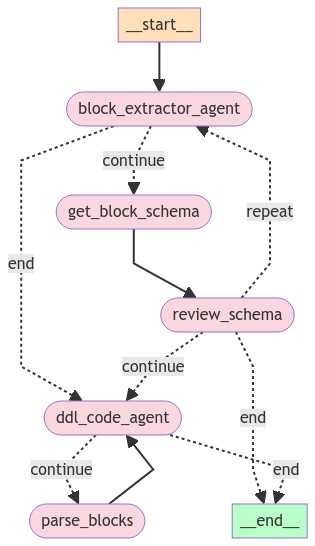

In [27]:
## Create Final Graph (will move this to another file ultimately)
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)  # Plan the process
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("get_block_schema",block_extractor_agent.call_tool)
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("get_block_schema", "review_schema")
workflow.add_edge("parse_blocks", "ddl_code_agent")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "block_extractor_agent",
    should_block_schema_continue,
    {
        "continue":"get_block_schema",
        "end": "ddl_code_agent"
    }   
)
# Check if block schema is correct via human review
workflow.add_conditional_edges(
    "review_schema",
    block_schema_review_continue,
    {
        "continue":"ddl_code_agent",
        "repeat": "block_extractor_agent",
        "end": END
    }   
)
# Check if DDL has finished tool calls
workflow.add_conditional_edges(
    "ddl_code_agent",
    should_block_schema_continue,
    {
        "continue":"parse_blocks",
        "end": END
    }   
)

app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [28]:
# from langchain_core.messages import HumanMessage

# question = """
#     Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, 
#     I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from 
#     args that are decoded from base64-encoded JSON. I only need actions for successful receipts.
# """

# result = app.invoke({"messages": [HumanMessage(content=question)], 
#                      "block_schema": "",
#                      "js_code":"",
#                      "ddl_code":"",
#                      "dml_code": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result)

# Notes
### 1. Forced Schema Output
- This is determined at the model level, we have 2 options

a. Add .partial to the prompt - this is NON-deterministic

`dml_parser = PydanticOutputParser(pydantic_object=DMLResponse)`

`prompt(<PROMPT>).partial(format_instructions=dml_parser.get_format_instructions())`

b. When creating the model in LCEL - this IS deterministic

`model = {"messages": RunnablePassthrough()} | prompt | llm.with_structured_output(DMLResponse)`

Note: if you do this, you have to make sure to wrap the response in a SystemMessage

`response = self.model.invoke(messages)`

`wrapped_message = SystemMessage(content=str(response))`


**When agents perform parallel tool calling, we want to use a, when agents just spit out code, we want b.**

### 2. Issues with reliable JS block parsing generation and execution
- I'm not getting reliable JS code that can be run from block extractor agent
- Even when hard coding working JS code into DDL agent, I'm not able to reliably parse block schema with the JS using tool call
- We have to be careful about string replacement: \n, and {} mess a lot of stuff up